# 【枠回しのアルゴリズム】

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy

## 実際に算出された号数を用いて実践する

In [2]:
# サンプルデータの確認。
!ls sample/

df_CCJC_sample.txt  df_Monde_sample.txt  df_kao_sample.txt
df_GSK_sample.txt   df_SB_sample.txt


In [3]:
df_a = pd.read_csv('sample/df_CCJC_sample.txt', index_col=0)
df_b = pd.read_csv('sample/df_Monde_sample.txt', index_col=0)
df_c = pd.read_csv('sample/df_kao_sample.txt', index_col=0)
df_d = pd.read_csv('sample/df_GSK_sample.txt', index_col=0)
df_e = pd.read_csv('sample/df_SB_sample.txt', index_col=0)

***
***
<b>　指定階層ごとの枠視聴率の相関係数を調べる。<br>
　「相関係数が小さい＝交換する価値が高い」ことに注意</b>

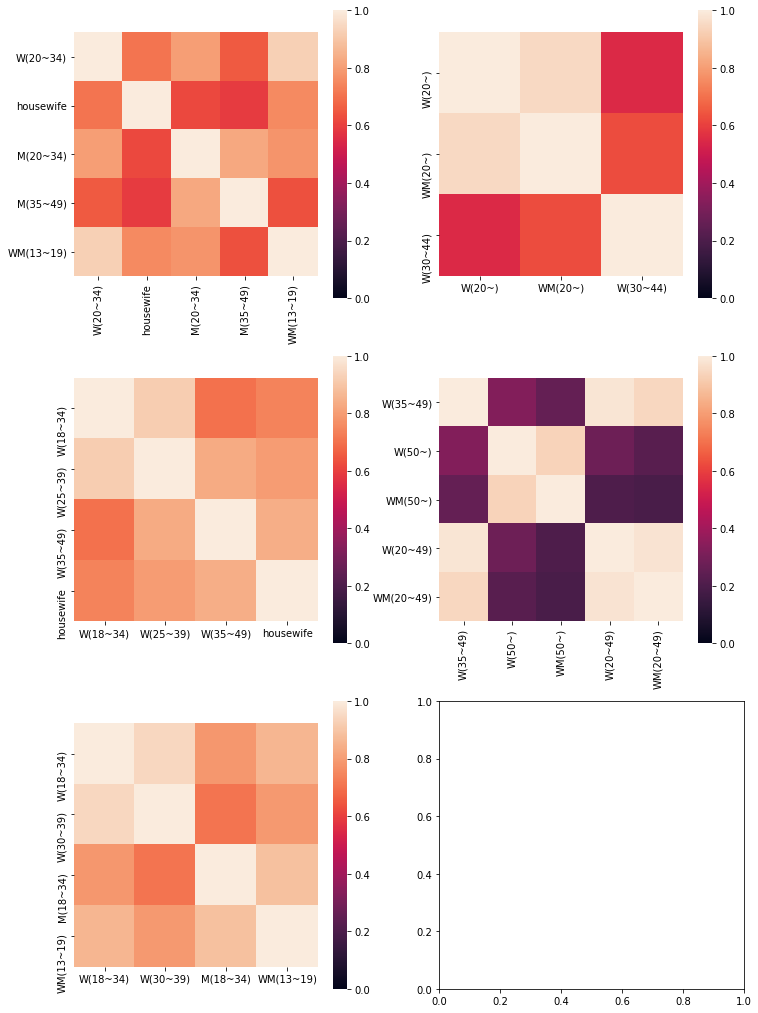

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
sns.heatmap(df_a.drop(['世帯','◆ＡＬＬ','号数(6)'], axis=1).corr(),vmax=1,vmin=0,square=True,ax=axes[0, 0])
sns.heatmap(df_b.drop(['世帯','◆ＡＬＬ','号数(6)'], axis=1).corr(),vmax=1,vmin=0,square=True,ax=axes[0, 1])
sns.heatmap(df_c.drop(['世帯','◆ＡＬＬ','号数(6)'], axis=1).corr(),vmax=1,vmin=0,square=True,ax=axes[1, 0])
sns.heatmap(df_d.drop(['世帯','◆ＡＬＬ','号数(6)'], axis=1).corr(),vmax=1,vmin=0,square=True,ax=axes[1, 1])
sns.heatmap(df_e.drop(['世帯','◆ＡＬＬ','号数(6)'], axis=1).corr(),vmax=1,vmin=0,square=True,ax=axes[2, 0])
plt.show()

***
***

In [5]:
print('クライアントaのデータ数:{}'.format(len(df_a)))
print('クライアントbのデータ数:{}'.format(len(df_b)))
print('クライアントcのデータ数:{}'.format(len(df_c)))
print('クライアントdのデータ数:{}'.format(len(df_d)))
print('クライアントeのデータ数:{}'.format(len(df_e)))

クライアントaのデータ数:1220
クライアントbのデータ数:59
クライアントcのデータ数:1998
クライアントdのデータ数:482
クライアントeのデータ数:107


## 様々なデータの分布の確認

In [6]:
# 全てのデータを連結する。
df_all = pd.concat([df_a.loc[:, ["世帯","号数(6)"]],
                    df_b.loc[:, ["世帯","号数(6)"]],
                    df_c.loc[:, ["世帯","号数(6)"]],
                    df_d.loc[:, ["世帯","号数(6)"]],
                    df_e.loc[:, ["世帯","号数(6)"]]])

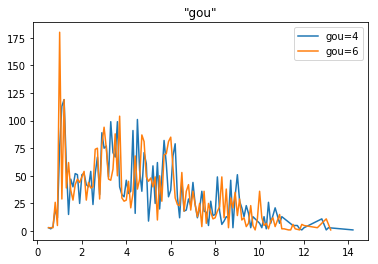

In [7]:
# 単純に、号数ごとの値を見ている。
plt.plot(df_all.groupby('世帯').size(), label='gou=4')
plt.plot(df_all.groupby('号数(6)').size(), label='gou=6')
plt.title('"gou"')
plt.legend()
plt.show()

In [8]:
df_all['号数の差'] = df_all['世帯'] - df_all['号数(6)']

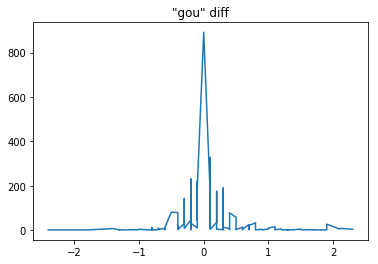

In [9]:
# 号数の差。
plt.plot(df_all.groupby('号数の差').size())
plt.title('"gou" diff')
plt.show()

<b>号数が変わることによる予測視聴率の差は、かなりとがった(分散の小さい)正規分布に従うことがわかる。</b>

***

<b>データ量の関係から、今回はクライアントaとcを用いて指定枠の違いによる予測視聴率の差を見る。</b>

In [10]:
df_A = df_a.loc[:, ['世帯','号数(6)','W(20~34)','housewife']]
df_B = df_c.loc[:, ['世帯','号数(6)','W(18~34)','housewife']]
df_A.columns=['A_gou', 'B_gou', 'A_target','B_target']
df_B.columns = df_A.columns

In [11]:
df = pd.concat([df_A, df_B])

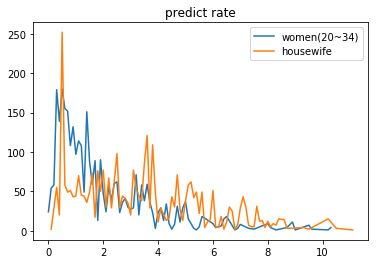

In [12]:
# 指定階層ごとの予測視聴率。
plt.plot(df.groupby('A_target').size(), label='women(20~34)')
plt.plot(df.groupby('B_target').size(), label='housewife')
plt.title('predict rate')
plt.legend()
plt.show()

In [13]:
# 視聴率の上昇具合には同じ傾向があることが確認された。
df.loc[:, ['A_target', 'B_target']].corr()

,A_target,B_target
A_target,1.000000,0.749088
B_target,0.749088,1.000000


<b>視聴率の分布にそこまで差はないように感じるが…</b>

In [14]:
df['階層間格の視聴率差'] = df['B_target'] - df['A_target']
df = df.round(1)

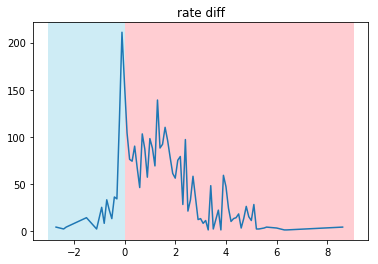

In [15]:
# 号数の差。
plt.plot(df.groupby('階層間格の視聴率差').size())
plt.title('rate diff')
plt.axvspan(-3,0,color="#CEECF5")
plt.axvspan(0,9,color="#ffcdd2")
plt.show()

<b>概ねどの枠に対しても、主婦の方が20~34才の女性よりも視聴率が高い（もしくは変わらない）という結果が出た。<br>
これより、ターゲットの層による視聴率の格差はかなり大きいものと予測されるため、これを考慮に入れる必要があると考えられる。</b>

***

## アルゴリズム

In [16]:
# 利用するデータ。
df_A = df_a.loc[:, ['世帯','号数(6)','W(20~34)','housewife']]
df_B = df_c.loc[:, ['世帯','号数(6)','W(18~34)','housewife']]
df_A.columns=['A_gou', 'B_gou', 'A_target','B_target']
df_B.columns = df_A.columns

In [17]:
# データの確認
display(df_A.head(1))
display(df_B.head(1))

,A_gou,B_gou,A_target,B_target
0,8.7,6.6,3.9,6.5


,A_gou,B_gou,A_target,B_target
0,10.4,10.0,5.7,8.1


***

<b>
    　枠回しの条件は、
    - 号数は変わらない（ほんの少しUPは「許容」）
    - 視聴率は、上昇する（もしくは、変わらない。）
</b>
<b>
    　ここで、<font color='Red'>交換に使用する枠の選び方</font>が問題であり、例えば「交換して予測視聴率が大きく上がるもの」という選択の仕方をすると、主婦をターゲットにしているクライアントは、先ほどの図の<font color='#CEECF5'>水色部分</font>しか交換に出せなくなり、あまり良い結果に結びつくとは考えにくい。<br>
    　しかしその一方で「全ての枠」という選択の仕方をすると、交換したら予測視聴率が8も下がるような枠を出される可能性があり、それはそれで良い結果に結びつくとは考えにくい。
</b>

<b>
    　以上の考察から、有利な側（ここでは主婦側。自分の方が予測視聴率が高い枠が多い側）は<font color='Red'>ある閾値を用い、それより高いものだけを交換に利用する</font>という方法をとる。<br>
    　閾値の選び方は平均値、中央値、第三四分位点、などの方法があるが、それは後々調整する。<br>
    　不利な側は、「全ての枠」を出しても良いし、「交換して予測視聴率が大きく上がるもの」だけを出しても良い。ここも調整する。
<br>

In [18]:
# 枠を全て結合し、平均値を求めて比較する。
df = pd.concat([df_A, df_B])
print("Aのターゲット階層の平均予測視聴率は{}であり、".format(round(df["A_target"].mean(),2)))
print("Bのターゲット階層の平均予測視聴率は{}である。" .format(round(df["B_target"].mean(),2)))

Aのターゲット階層の平均予測視聴率は1.94であり、
Bのターゲット階層の平均予測視聴率は3.31である。


<b>今回はクライアントBの方が有利なので、調整が必要！</b>

In [19]:
# value_diffは、相手に交換した時にどれだけ良くなるか、を示していることに注意！！
df_A['A_value'] = df_A['A_target']/df_A['A_gou']
df_A['B_value'] = df_A['B_target']/df_A['B_gou']
df_A['value_diff'] = df_A['B_value'] - df_A['A_value']

df_B['A_value'] = df_B['A_target']/df_B['A_gou']
df_B['B_value'] = df_B['B_target']/df_B['B_gou']
df_B['value_diff'] = df_B['A_value'] - df_B['B_value']

In [20]:
df['A_value'] = df['A_target']/df['A_gou']
df['B_value'] = df['B_target']/df['B_gou']

In [21]:
df = df.round(1) #めちゃめちゃざっくりした分布を確認するため。

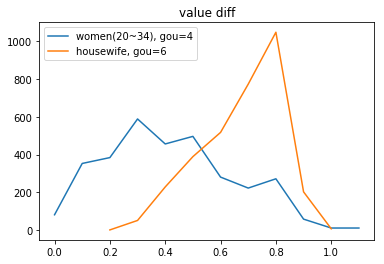

In [22]:
plt.plot(df.groupby('A_value').size(), label='women(20~34), gou=4')
plt.plot(df.groupby('B_value').size(), label='housewife, gou=6')
plt.title('value diff')
plt.legend()
plt.show()

In [23]:
print("Aは、Bに渡すと枠の'value'が平均的に{}高く、".format(round(df_A['value_diff'].mean(),3)))
print("Bは、Aに渡すと枠の'value'が平均的に{}高くなる。" .format(round(df_B['value_diff'].mean(),3)))

Aは、Bに渡すと枠の'value'が平均的に0.191高く、
Bは、Aに渡すと枠の'value'が平均的に-0.3高くなる。


<b>
    　この値'value'は、クライアントごとに「ターゲット階層の予測視聴率」を「指定号数」で割った値の分布を表している。<br>
    　このことからも、単純に値だけを見ると主婦をターゲットとしているクライアントBの方が「有利」だとわかる。
</b>

### 【有利な方の処理】

In [24]:
# 値を分ける。
N_cut = 5
labels = [i+1 for i in range(N_cut)]
df_temp = pd.concat([df_B,
                     pd.qcut(df_B['value_diff'], N_cut, labels=labels, retbins=False).rename(columns={'value_diff':0})],
                    axis=1)

In [25]:
# 0のカラムが、大きさごとに分けるラベルの役割をしている。
df_temp.head(3)

,A_gou,B_gou,A_target,B_target,A_value,B_value,value_diff,0
0,10.4,10.0,5.7,8.1,0.548077,0.810000,-0.261923,3
1,6.1,6.6,4.1,5.4,0.672131,0.818182,-0.146051,4
2,6.1,6.6,4.1,5.4,0.672131,0.818182,-0.146051,4


In [26]:
# 分かれた後の数の分布。
df_temp.groupby(0).size()

0
1    400
2    400
3    399
4    400
5    399
dtype: int64

In [27]:
# 分かれた後の平均値。
df_temp.groupby(0)['value_diff'].mean()

0
1   -0.587421
2   -0.447790
3   -0.330317
4   -0.161352
5    0.027227
Name: value_diff, dtype: float64

<b>　この分け方だと、「labelの値が小さい」＝「vallue_diffも小さい」という関係だということがわかる。</b>

In [28]:
# 上昇率が上位(2/5)のものを利用することにする。（あまりにも小さいものは使えないため。）
df_B_pickup = df_temp[df_temp[0] >= 3].reset_index(drop=True)

### 【不利な方の処理】

<b>　既に持っており、自分の場所にある方が良い枠を渡してしまうのは勿体無いので、それだけ防ぐ。</b>

In [29]:
# value_diff > 0 ↔︎相手の方が良い枠のみにする。
df_A_pickup = df_A[df_A['value_diff']>0].reset_index(drop=True)

<b>　ここまでで、交換に利用するデータの抽出は完了した。</b>

### 【プログラムの中身】
<b>
    　ここまでで選んだ枠の号数の和を計算する。<br>
    →小さい方の枠を、「全て交換に利用する」とする。<br>
    →その枠で、号数(小)/号数(大)が計算できる。<br>
    →大きい方は、号数(小)/号数(大)が上記の値と一致（ほんの少しでかくなるはOK）しつつ号数(大)が一致する（ほんの少し小さくなるはOK）ように枠を取得して行く。

In [30]:
# データの確認
display(df_A_pickup.head(3))
display(df_B_pickup.head(3))

,A_gou,B_gou,A_target,B_target,A_value,B_value,value_diff
0,8.7,6.6,3.9,6.5,0.448276,0.984848,0.536573
1,5.7,5.5,3.5,4.2,0.614035,0.763636,0.149601
2,5.7,5.5,3.5,4.2,0.614035,0.763636,0.149601


,A_gou,B_gou,A_target,B_target,A_value,B_value,value_diff,0
0,10.4,10.0,5.7,8.1,0.548077,0.810000,-0.261923,3
1,6.1,6.6,4.1,5.4,0.672131,0.818182,-0.146051,4
2,6.1,6.6,4.1,5.4,0.672131,0.818182,-0.146051,4


In [31]:
print("Aの選んだ枠は、A指定の号数だと{}で、B指定の号数だと{}".format(df_A_pickup['A_gou'].sum(),df_A_pickup['B_gou'].sum()))
print("Bの選んだ枠は、A指定の号数だと{}で、B指定の号数だと{}".format(df_B_pickup['A_gou'].sum(),df_B_pickup['B_gou'].sum()))

Aの選んだ枠は、A指定の号数だと3485.9で、B指定の号数だと3427.4
Bの選んだ枠は、A指定の号数だと6131.6で、B指定の号数だと6224.1


In [60]:
len(df_A_pickup)

792

In [62]:
len(df_B_pickup)

1198

<b>　ともにAの選んだ枠の方が小さいので、これらの枠を全て交換に利用するとする。<br>
　つまり、Bは、それぞれの指定号数を満たすように枠選択をする必要がある。</b>

In [32]:
# それぞれの値を計算する。
A_gou_aim = df_A_pickup['A_gou'].sum()
B_gou_aim = df_A_pickup['B_gou'].sum()
A_B_rate_aim = A_gou_aim/B_gou_aim

In [33]:
# つまるとこと
print('大きい方の目標号数は{}である。また、比率は{}を目指す。'.format(B_gou_aim, A_B_rate_aim))

大きい方の目標号数は3427.4である。また、比率は1.0170683316799907を目指す。


***
<b>　じゃあ、これをどうやるか</b>

In [34]:
# 上記の値と同じカラムを作成する。
df_B_pickup['A_B_rate'] = df_B_pickup['A_gou']/df_B_pickup['B_gou']

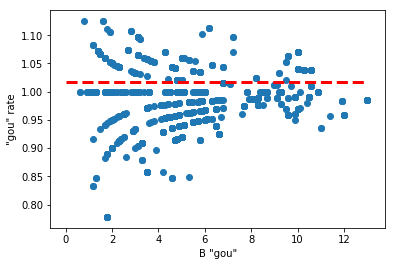

In [63]:
# 散布図。青線が目標値。
plt.xlabel('B "gou"')
plt.ylabel('"gou" rate')
plt.hlines(y=A_B_rate_aim, xmin=0, xmax=13, colors='red', linestyles='dashed', linewidths=3)
plt.scatter(df_B_pickup['B_gou'], df_B_pickup['A_B_rate'])
plt.show()

<b>　とりあえず取っていき、rateが目標の値に近づくようにバイアスをかけながら取りに行き、最終的に目標値付近で収束して微調整というのが理想。`AdaGrad`的なイメージ。（以下の計算式参照）ただし、この場合計算量はどれぐらいになるだろうか…</b>

<div style="text-align: center;">
    $h_{0} = \epsilon\\
    h_{t} = h_{t−１} + (R_{aim} - R_{t})^{2}\\
    \eta_{t} = \frac{\eta_{0}}{\sqrt{h_{t}}}\\
    R_{t+1} = R_{t} - 2 \eta_{t} (R_{aim} - R_{t})$
</div>

<b>　この時、最初の値を最大値（らへん）にし、$\eta_{0}=1$とすればいけるような気がしている。</b>

In [36]:
# 使用する値は、この2カラム。
df_B_pickup.loc[:2, ['B_gou', 'A_B_rate']]

,B_gou,A_B_rate
0,10.0,1.040000
1,6.6,0.924242
2,6.6,0.924242


<b>　numpyの方が計算が早いので、numpyを利用する。</b>

In [37]:
X_arr = df_B_pickup['B_gou'].values
R_arr = df_B_pickup['A_B_rate'].values

In [38]:
# 初期化する。

X_aim = B_gou_aim    # 号数の目標値
R_aim = A_B_rate_aim # 比率の目標値
R_n = max(R_arr)     # R0を今持っている値の最大値で初期化
h_n = 1              # h0を1で初期化
eta_0 = 1            # eta0を１で初期化

In [39]:
print('目標号数は {} で、目標比率は {} である。'.format(round(X_aim,4), round(R_aim,4)))
print('最初に取りに行く比率は {} である。'.format(round(R_n,4)))
print('hの初期値は {} である。'.format(h_n))
print('η(学習率)の初期値は {} である。'.format(eta_0))

目標号数は 3427.4 で、目標比率は 1.0171 である。
最初に取りに行く比率は 1.125 である。
hの初期値は 1 である。
η(学習率)の初期値は 1 である。


***

<b>【メインプログラム】</b>

In [40]:
# np.arrayからある値numに最も近い値とそのindexを返す関数
def getNearestValue(arr, num):
    """
    @param arr: データ配列
    @param num: 対象値
    @return 対象値に最も近い値
    """
    # リスト要素と対象値の差分を計算し最小値のインデックスを取得
    idx = np.abs(np.asarray(arr) - num).argmin()
    return arr[idx], idx

In [57]:
def main(X_aim, X_arr_, R_arr_, R_n, h_n=1, eta_0=1):
    """
    @param X_aim : 目標となる合計号数値
    @param X_arr_: 枠の号数の値
    @param R_arr_: 枠の号数の比率
    @param R_n   : 最初にとる値。(今回は最大値。)
    @param h_n   : h0の初期値
    @param eta_0 : ηの初期値
    @return 取得した全index
    """
    start = time.time()
    
    idxes = [] # とった枠のindexを入れていく。
    X_arr = copy.deepcopy(X_arr_) # 参照先の違うオブジェクトを作成することで、
    R_arr = copy.deepcopy(R_arr_) # 関数内で利用されても値を変えないようにする。
    while(X_aim>0):
        R_n, idx = getNearestValue(R_arr, R_n) 
        X_aim -= X_arr[idx] # 目標値から引いていく。
        R_arr[idx] = -100 # -100で値を修正する。（もう一度選ばれることを避けるため）
        h_n += (R_aim-R_n)**2 # hnの値を更新する。
        eta_n = eta_0/h_n**(1/2) # etaの値も更新する。
        R_n = R_n + 2*eta_n*(R_aim-R_n) # Rnの値を更新する。
        idxes.append(idx) # indexを格納していく。
        
    end = time.time()
    print("処理時間は {} 秒でした。".format(np.round((end-start), 3)))
    print("ηの最終的な値は {} で、h の最終的な値は {} でした。".format(round(eta_n,4), round(h_n,4)))
    print("最後に取った枠の比率は {} で、目指していた比率は {} でした。".format(round(R_n,4), round(R_aim,4)))
    print("結果的に号数は {} だけ目標値を上回りました。".format(round(-X_aim, 4)))
    return idxes

In [58]:
get_idxes = main(X_aim, X_arr, R_arr, R_n)

処理時間は 0.006 秒でした。
ηの最終的な値は 0.7992 で、h の最終的な値は 1.5658 でした。
最後に取った枠の比率は 1.0273 で、目指していた比率は 1.0171 でした。
結果的に号数は 4.4 だけ目標値を上回りました。


***

### 結果の可視化

/home/dataartist/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


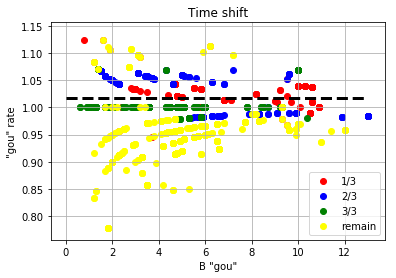

In [59]:
N_index = len(get_idxes)//3 # 1/3ずつ順に可視化して行く。
remain_idxes = list(set([i for i in range(len(df_B_pickup))]) - set(get_idxes)) # 取られなかったインデックス。

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(df_B_pickup.loc[get_idxes[:N_index]]['B_gou'], df_B_pickup.loc[get_idxes[:N_index]]['A_B_rate'], c='red', label='1/3')
ax.scatter(df_B_pickup.loc[get_idxes[N_index:2*N_index]]['B_gou'], df_B_pickup.loc[get_idxes[N_index:2*N_index]]['A_B_rate'], c='blue', label='2/3')
ax.scatter(df_B_pickup.loc[get_idxes[2*N_index:]]['B_gou'], df_B_pickup.loc[get_idxes[2*N_index:]]['A_B_rate'], c='green', label='3/3')
ax.scatter(df_B_pickup.loc[remain_idxes]['B_gou'], df_B_pickup.loc[remain_idxes]['A_B_rate'], c='yellow', label='remain')

plt.hlines(y=A_B_rate_aim, xmin=0, xmax=13, colors='black', linestyles='dashed', linewidths=3) #目標値
ax.set_title('Time shift')
ax.set_xlabel('B "gou"')
ax.set_ylabel('"gou" rate')

ax.grid(True)

ax.legend(loc='lower right')
fig.show()

<b>
    　結構いい感じで取得できている。<br>
    　この後の改善点は、<br>
    - 目標軸上の点を先にとってしまっているので、それを避ける。
      1. 学習率を高める
      2. ある閾値を決めて、近くは最後まで取らないようにする。
    - 最後の処理(今は超えたら終了になっているが、Bの方も合わせる)を行う。
    - 他のデータでもいけるかを試す。
</b>

***
***

<b>・学習率を高める。</b>

In [64]:
get_idxes = main(X_aim, X_arr, R_arr, R_n, eta_0=1.5)

処理時間は 0.006 秒でした。
ηの最終的な値は 0.9697 で、h の最終的な値は 2.3927 でした。
最後に取った枠の比率は 1.0331 で、目指していた比率は 1.0171 でした。
結果的に号数は 7.9 だけ目標値を上回りました。


/home/dataartist/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


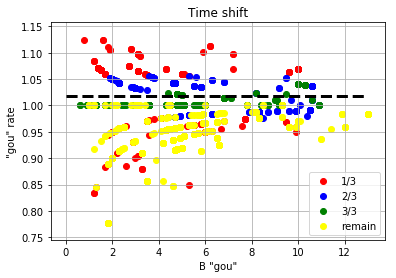

In [65]:
N_index = len(get_idxes)//3 # 1/3ずつ順に可視化して行く。
remain_idxes = list(set([i for i in range(len(df_B_pickup))]) - set(get_idxes)) # 取られなかったインデックス。

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(df_B_pickup.loc[get_idxes[:N_index]]['B_gou'], df_B_pickup.loc[get_idxes[:N_index]]['A_B_rate'], c='red', label='1/3')
ax.scatter(df_B_pickup.loc[get_idxes[N_index:2*N_index]]['B_gou'], df_B_pickup.loc[get_idxes[N_index:2*N_index]]['A_B_rate'], c='blue', label='2/3')
ax.scatter(df_B_pickup.loc[get_idxes[2*N_index:]]['B_gou'], df_B_pickup.loc[get_idxes[2*N_index:]]['A_B_rate'], c='green', label='3/3')
ax.scatter(df_B_pickup.loc[remain_idxes]['B_gou'], df_B_pickup.loc[remain_idxes]['A_B_rate'], c='yellow', label='remain')

plt.hlines(y=A_B_rate_aim, xmin=0, xmax=13, colors='black', linestyles='dashed', linewidths=3) #目標値
ax.set_title('Time shift')
ax.set_xlabel('B "gou"')
ax.set_ylabel('"gou" rate')

ax.grid(True)

ax.legend(loc='lower right')
fig.show()